In [31]:
import time
import json
from data_crawler import data_crawler


# { period : [ limit, milliseconds ] } (limit <= 200)
supported_period = { "1m" : [ 100,  60000 ],
                     "5m" : [ 100, 300000 ],
                     "15m" : [ 100, 900000 ],
                     "1H" : [ 100, 3600000 ],
                     "6H" : [ 100, 21600000 ] }

# { period : [ datas, lasttime ] }
download_format = { "1m" : [ None, None ],
                    "5m" : [ None, None ],
                    "15m" : [ None, None ],
                    "1H" : [ None, None ],
                    "6H" : [ None, None ] }  

supported_ticker = { "BTCUSDT_UMCBL" }
ticker = "BTCUSDT_UMCBL"

data_crawler = data_crawler(None, supported_ticker, supported_period, download_format)

datas = data_crawler.get_downloaded_datas()[ticker]

for period in download_format.keys():
    result = datas[period][0]
    print(period, type(result), len(result))
    
# [ 'timestamp in milliseconds', 'Opening price', 'Highest price', 'Lowest price', 'Close price',
#   'Base currency trading volume', `Quote currency trading volume` ]

Succeed to download datas [BTCUSDT_UMCBL / 1m / 1695963030171 / 1695969030171]
Succeed to download datas [BTCUSDT_UMCBL / 5m / 1695939030171 / 1695969030171]
Succeed to download datas [BTCUSDT_UMCBL / 15m / 1695879030171 / 1695969030171]
Succeed to download datas [BTCUSDT_UMCBL / 1H / 1695609030171 / 1695969030171]
Succeed to download datas [BTCUSDT_UMCBL / 6H / 1693809030171 / 1695969030171]
1m <class 'list'> 100
5m <class 'list'> 100
15m <class 'list'> 100
1H <class 'list'> 100
6H <class 'list'> 100


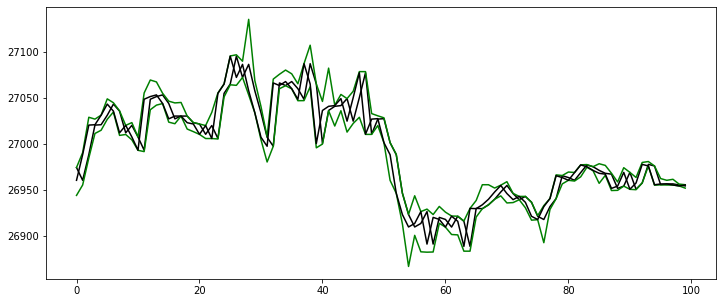

In [32]:
# 가격 분석하기 (매물대 확률분포) (테스트)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

period = "5m" # 봉 기준
results = datas[period][0] # 데이터

for idx, result in enumerate(results):
    result = list(map(float, result))
    results[idx] = result
    
results = pd.DataFrame(results, columns=['time', 'open', 'high', 'low', 'close', 'volume', 'q_volume'])

plt.figure(figsize=(12,5))
plt.plot(results['open'], 'black')
plt.plot(results['high'], 'green')
plt.plot(results['low'], 'green')
plt.plot(results['close'], 'black')
plt.show()